# SRCNN on MNIST and CIFAR-10

This is an implementation of SRCNN that mostly follows the core setup presented in the [original paper](https://arxiv.org/pdf/1501.00092v3.pdf). Main differences:

- Different optimizer, Adam, as opposed to SGD.
- The original paper only presents results on color images and primarily uses a preprocessing *trick* transforming from RGB color space to YCbCr color space and only training on Y (illuminance). They also in the end present good results working directly on the RGB channels. The latter is what is done in this implementation.
- In the paper they trained on sub-images of images in the ImageNet dataset.
- The paper is not using *same* zero padding to keep the dimensions of the output image equal to the dimensions of the input. Their way of ensuring this is a bit involved, and to my eyes zero padding seems to be working (at least on MNIST).

Results on CIFAR-10 is not the most impressive, but I believe this is mainly due to the very low resolution of these images compared to what they actually are depicting. This is probably a dataset pretty unsuitable for SR.

https://paperswithcode.com/paper/image-super-resolution-using-deep

In [ ]:
import numpy as np
import cv2
import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path


import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.initializers import RandomNormal

# Check GPUs:",
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Prevent TensorFlow from allocating all memory of all GPUs:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Parameters

In [ ]:
# Uncomment the dataset you want to run on
DATASET = 'MNIST'
#DATASET = 'CIFAR-10'

EPOCHS = 20
BATCH_SIZE = 64
DOWNSAMPLE_FACTOR = 4
DOWNSAMPLE_METHOD = cv2.INTER_CUBIC
#HEIGHT, WIDTH = (28, 28)
HEIGHT, WIDTH = (None, None)

# Load Dataset (MNIST or CIFAR-10)

http://yann.lecun.com/exdb/mnist/

https://www.cs.toronto.edu/~kriz/cifar.html

In [ ]:
if DATASET == 'MNIST':
    (hr_train, train_labels) , (hr_test, test_labels) = mnist.load_data()

elif DATASET == 'CIFAR-10':
    (hr_train, train_labels) , (hr_test, test_labels) = cifar10.load_data()

# Downsample (and upsample) images

Currently downsampling and upsampling to degrade the image (this is most in line with the original paper).

- x is input to the neural net and is the degraded (downsampled+upsampled) image
- y is ground truth (the HR, undegraded image)

In [ ]:
def degrade_image(img, factor):
    #print(img.shape)
    if len(img.shape) == 3:
        h, w, _ = img.shape
    elif len(img.shape) == 2:
        h, w = img.shape
        
    new_height = int(h / factor)
    new_width = int(w / factor)

    # resize the image - down
    img = cv2.resize(img, (new_width, new_height), interpolation = DOWNSAMPLE_METHOD)

    # resize the image - up
    img = cv2.resize(img, (w, h), interpolation = DOWNSAMPLE_METHOD)

    # save the image
    #print(img.shape)
    return img

In [ ]:
lr_train = np.array([degrade_image(image, DOWNSAMPLE_FACTOR) for image in hr_train])
lr_test = np.array([degrade_image(image, DOWNSAMPLE_FACTOR) for image in hr_test])

# Normalizing

In [ ]:
# Really just scaling, not normalizing
# From 0-255 ints to 0-1 floats
def normalize(ndarray):
    return ndarray.astype('float32')/255

# From 0-1 floats to 0-255 ints
def denormalize(ndarray):
    input_min = np.amin(ndarray)
    input_max = np.amax(ndarray)
    input_range = input_max - input_min
    scaled = np.array((ndarray - input_min) / float(input_range), dtype=np.float32)
    return np.array(scaled * 255, dtype=np.uint8)

In [ ]:
lr_train = normalize(lr_train)
lr_test = normalize(lr_test)
hr_train = normalize(hr_train)
hr_test = normalize(hr_test)

## (Expanding dimensions)

Necessary to be compatible with vanilla [Conv2D tf.keras layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D). 

In [ ]:
if DATASET == 'MNIST':
    lr_train = np.expand_dims(lr_train, -1)
    lr_test = np.expand_dims(lr_test, -1)
    hr_train = np.expand_dims(hr_train, -1)
    hr_test = np.expand_dims(hr_test, -1)

# Building the model

It is really quite straight-forward.

In [ ]:
def build_srcnn(channels_in, channels_out):
    
    srcnn = Sequential()
    
    srcnn.add(Conv2D(filters=128, kernel_size = (9, 9), 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.001, seed=None),
                     bias_initializer='zeros',
                     activation='relu', padding='same', use_bias=True, 
                     input_shape=(HEIGHT, WIDTH, channels_in)))

    srcnn.add(Conv2D(filters=64, kernel_size = (1, 1), 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.001, seed=None),
                     bias_initializer='zeros',
                     activation='relu', padding='same', use_bias=True))
    
    srcnn.add(Conv2D(filters=channels_out, kernel_size = (5, 5), 
                     kernel_initializer=RandomNormal(mean=0.0, stddev=0.001, seed=None), 
                     bias_initializer='zeros',
                     activation='linear', padding='same', use_bias=True))
    
    # define optimizer
    adam = Adam(lr=0.0003)
    
    # compile model
    srcnn.compile(optimizer=adam, loss='mean_squared_error', metrics=['mean_squared_error'])
    
    return srcnn

if DATASET == 'MNIST':
    srcnn = build_srcnn(channels_in = 1, channels_out = 1)
elif DATASET == 'CIFAR-10':
    srcnn = build_srcnn(channels_in = 3, channels_out = 3)
srcnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 128)   10496     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 64)    8256      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 1)     1601      
Total params: 20,353
Trainable params: 20,353
Non-trainable params: 0
_________________________________________________________________


# Training

In [ ]:
history = srcnn.fit(lr_train, 
                    hr_train, epochs = EPOCHS, 
                    batch_size = BATCH_SIZE,
                    validation_data = (lr_test, hr_test)
                   )

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 9s 151us/sample - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0354 - val_mean_squared_error: 0.0354
Epoch 2/20
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0344 - mean_squared_error: 0.0344 - val_loss: 0.0330 - val_mean_squared_error: 0.0330
Epoch 3/20
60000/60000 [==============================] - 6s 108us/sample - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0319 - val_mean_squared_error: 0.0319
Epoch 4/20
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0320 - mean_squared_error: 0.0320 - val_loss: 0.0312 - val_mean_squared_error: 0.0312
Epoch 5/20
60000/60000 [==============================] - 7s 109us/sample - loss: 0.0314 - mean_squared_error: 0.0314 - val_loss: 0.0307 - val_mean_squared_error: 0.0307
Epoch 6/20
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0310 - mean_squa

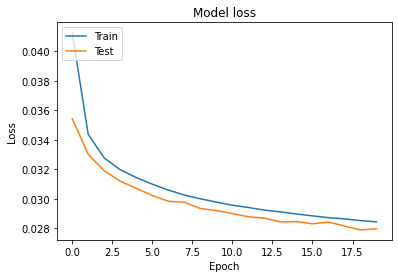

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Anecdotal comparison of predict vs ground truth

In [ ]:
def plot_comparison(lr, hr, label):
    sr = srcnn.predict(np.expand_dims(lr, axis = 0))[0,:,:,:]
    sr = denormalize(sr)
    lr = denormalize(lr)
    hr = denormalize(hr)
    if lr.shape[2] == 1:
        lr = lr[:,:,0]
        sr = sr[:,:,0]
        hr = hr[:,:,0]
        cmap = 'gray'
    elif lr.shape[2] == 3:
        cmap = None

    fig = plt.figure(figsize = (10,10))
    
    ax0 = fig.add_subplot(1,3,1)
    ax0.set_title('LR' + ', bicubic interpolation')
    ax0 = plt.imshow(lr, cmap = cmap)
    
    ax1 = fig.add_subplot(1,3,2)
    ax1.set_title('SRCNN')
    ax1 = plt.imshow(sr, cmap = cmap)
    
    ax2 = fig.add_subplot(1,3,3)
    ax2.set_title('HR (ground truth) - ' + str(label))
    ax2 = plt.imshow(hr, cmap = cmap)

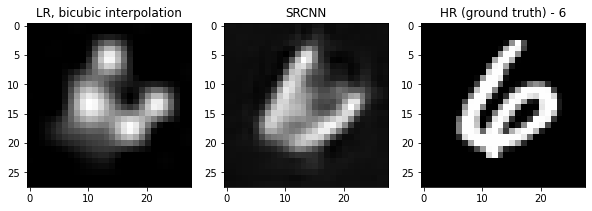

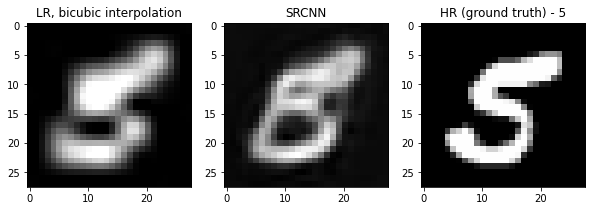

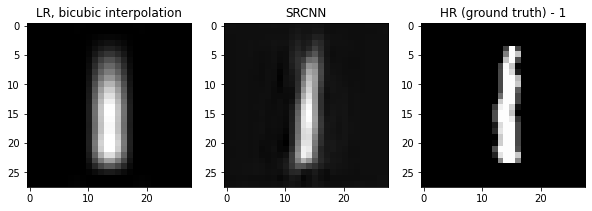

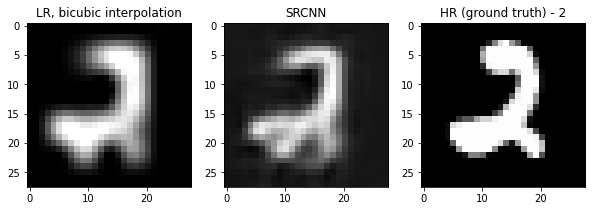

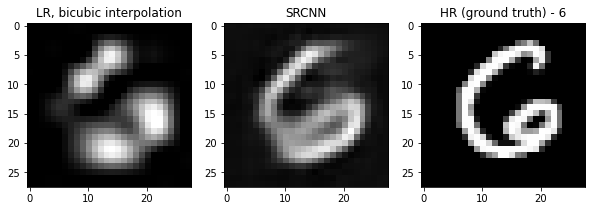

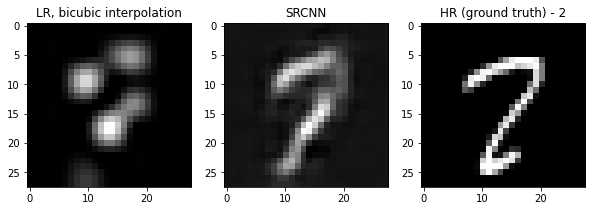

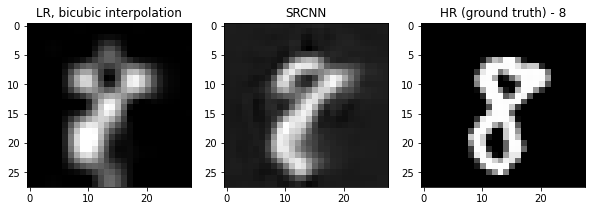

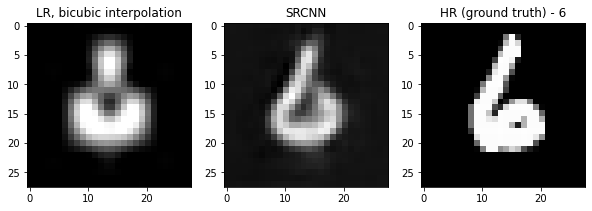

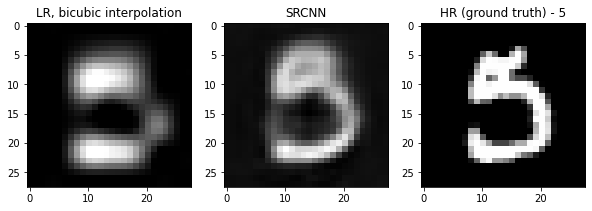

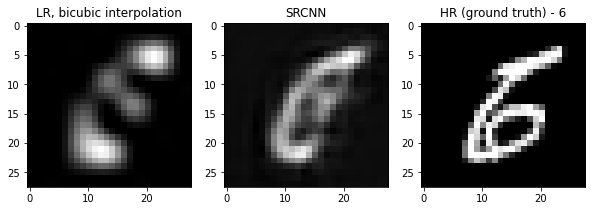

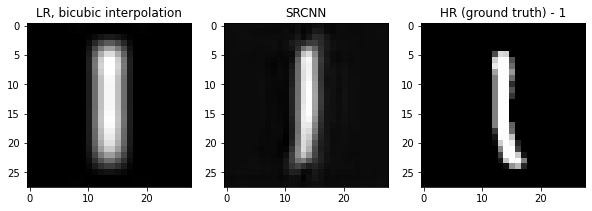

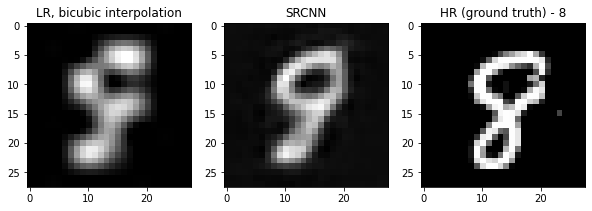

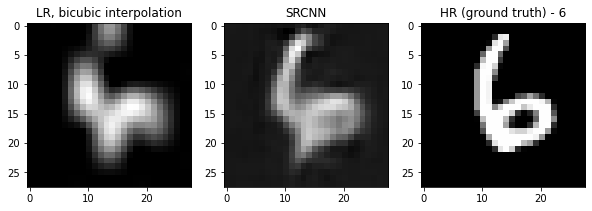

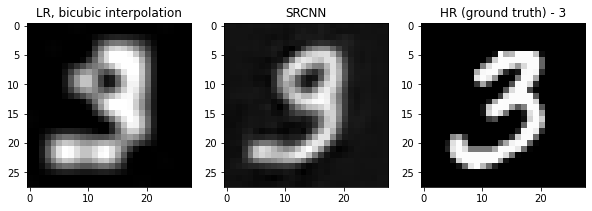

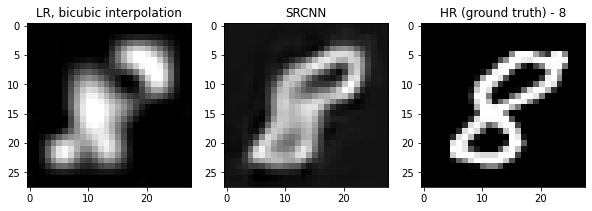

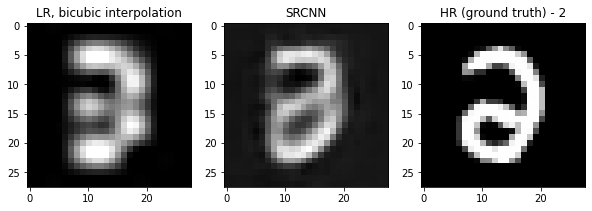

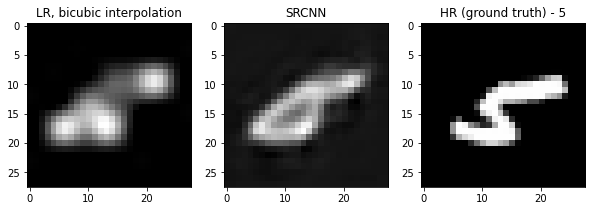

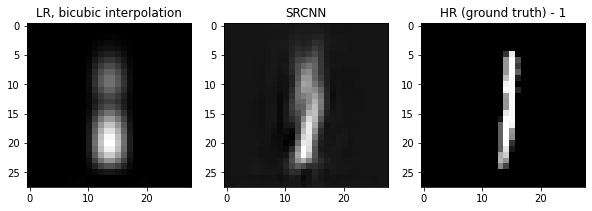

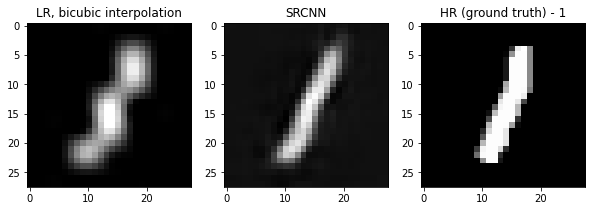

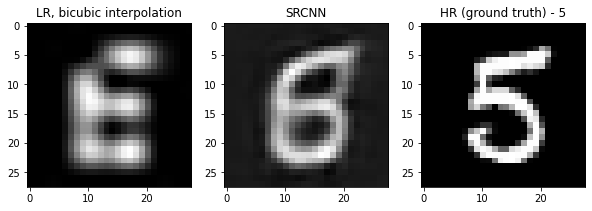

In [ ]:
random_idxs = np.random.randint(0, len(lr_test), size = 20)
for idx in random_idxs:
    plot_comparison(lr_test[idx,:,:,:], hr_test[idx,:,:,:], test_labels[idx])